In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Pulser imports
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, RampWaveform, BlackmanWaveform
from pulser_simulation import QutipEmulator, SimConfig

import networkx as nx
from scipy.spatial.distance import pdist, squareform

In [3]:
device_used = MockDevice
seed = 100

Define MIS Graph and Embedding

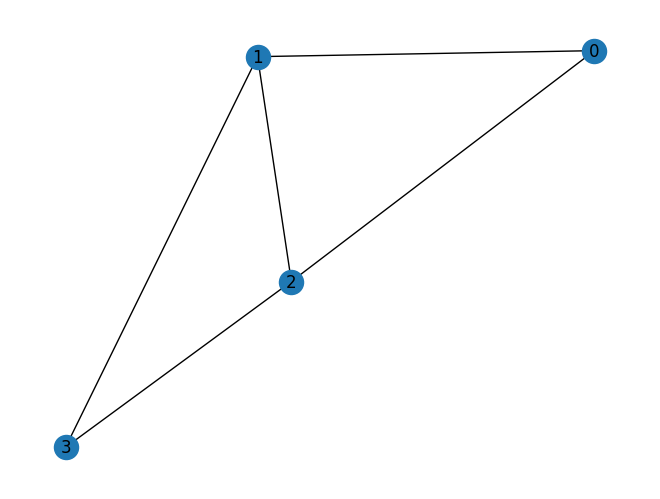

In [4]:
# Define nodes
N = 4

# Define graph and its layout
graph = nx.erdos_renyi_graph(n = N, p = 0.75, seed = seed)
pos = nx.spring_layout(graph, k = 0.5)

# Draw graph
nx.draw(graph, pos=pos)
nx.draw_networkx_labels(graph, pos=pos);

Classical Heuristic Approximation

In [5]:
ind_set = nx.approximation.maximum_independent_set(graph)
print("Heuristic solution: ", ind_set)

nil_string = np.zeros(len(graph), dtype=int)
for v in ind_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) # print the output string

Heuristic solution:  {0, 3}
Heuristic bitstring:  1001


MIS on NAQC

In [6]:
# Create a UD graph embedding using appropriate coordinates
coords = np.array(list(pos.values()))
val = np.min(pdist(coords))
coords *= 4/val # why?

In [7]:
squareform(device_used.interaction_coeff / pdist(coords) ** 6)

array([[   0.        ,  131.10446905,   61.6148369 ,    2.25699325],
       [ 131.10446905,    0.        , 1323.28089111,   27.09755307],
       [  61.6148369 , 1323.28089111,    0.        ,  389.83826813],
       [   2.25699325,   27.09755307,  389.83826813,    0.        ]])

In [8]:
# Interaction coefficient (U_ij or Q)
# U_ij = C_6/r**6
Q = squareform(device_used.interaction_coeff / pdist(coords) ** 6)

# Set Rabi frequency and Detuning
omega_max = np.median(Q[Q>0].flatten()) # why omega_max is taken as median
delta_0 = -5
delta_f = -delta_0

In [9]:
omega_max

96.35965297517119

In [10]:
dict(enumerate(coords))

{0: array([5.09969647, 2.78680436]),
 1: array([-0.77964974,  2.68120008]),
 2: array([-0.18951808, -1.27502851]),
 3: array([-4.13052865, -4.19297593])}

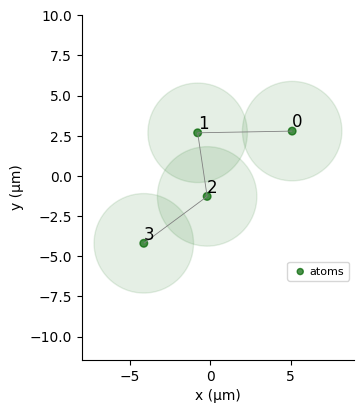

In [11]:
# Cretae a Register on NAQC
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius = device_used.rydberg_blockade_radius(omega_max),
    draw_graph = True,
    draw_half_radius = True, 
)

Define Pulse

In [12]:
# Set time values
t_rise = 800 # we need to set these values
t_sweep = 2000
t_fall = 800

In [13]:
# Set the pulse
rise = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_rise, start=0.0, stop=omega_max), detuning=delta_0, phase=0.0
)

sweep = Pulse.ConstantAmplitude(
    amplitude=omega_max, detuning=RampWaveform(duration=t_sweep, start=delta_0, stop=delta_f), phase=0.0
)

fall = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_fall, start=omega_max, stop=0.0), detuning=delta_f, phase=0.0
)

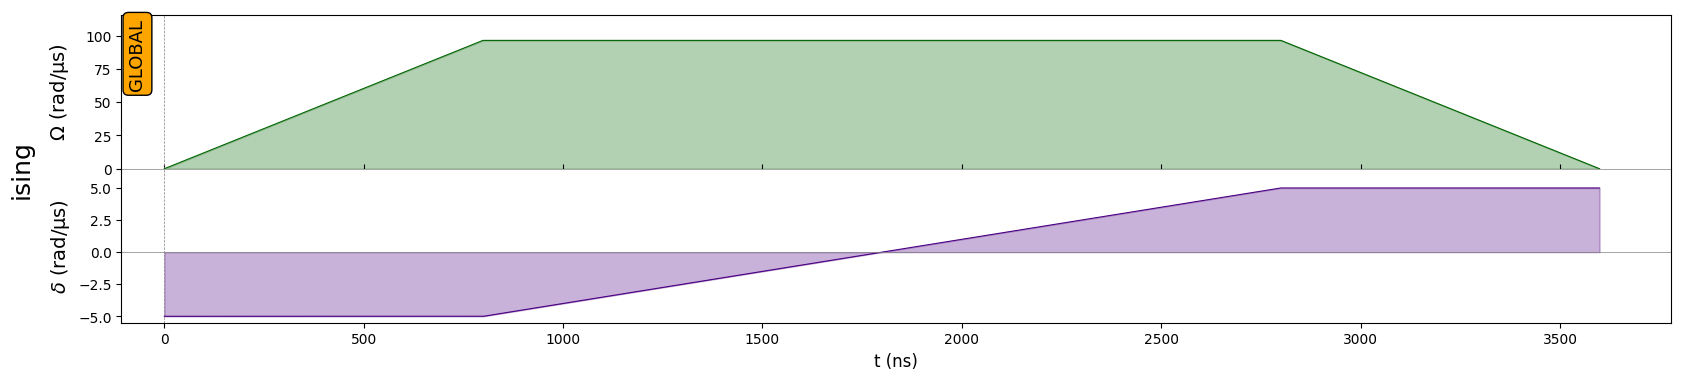

In [14]:
# Draw the pulse
seq = Sequence(reg, device_used)
seq.declare_channel("ising", "rydberg_global")
seq.add(rise, "ising", "no-delay")
seq.add(sweep, "ising", "no-delay")
seq.add(fall, "ising", "no-delay")
seq.draw()

Run Simulation

In [15]:
# Set noise configurations
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}

In [16]:
# Set simulator
simulator = QutipEmulator.from_sequence(
    sequence = seq,
    sampling_rate = 1,
    with_modulation = False,
    config = noise_config["noiseless"],
)

simulator.show_config()
results = simulator.run(progress_bar = True)
count_dict = results.sample_final_state(N_samples = 1000)

Options:
----------
Number of runs:        15
Samples per run:       5
10.0%. Run time:   0.07s. Est. time left: 00:00:00:00
20.0%. Run time:   0.18s. Est. time left: 00:00:00:00
30.0%. Run time:   0.26s. Est. time left: 00:00:00:00
40.0%. Run time:   0.36s. Est. time left: 00:00:00:00
50.0%. Run time:   0.45s. Est. time left: 00:00:00:00
60.0%. Run time:   0.55s. Est. time left: 00:00:00:00
70.0%. Run time:   0.64s. Est. time left: 00:00:00:00
80.0%. Run time:   0.72s. Est. time left: 00:00:00:00
90.0%. Run time:   0.82s. Est. time left: 00:00:00:00
Total run time:   0.91s


In [17]:
# Check results
print(count_dict)

Counter({'1001': 257, '0000': 200, '0001': 173, '1000': 144, '0100': 137, '0010': 67, '0101': 22})


Results

In [18]:
# CHeck most frequent resulting bitstring
most_frequent = {k:v for k, v in count_dict.items() if v>10}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))

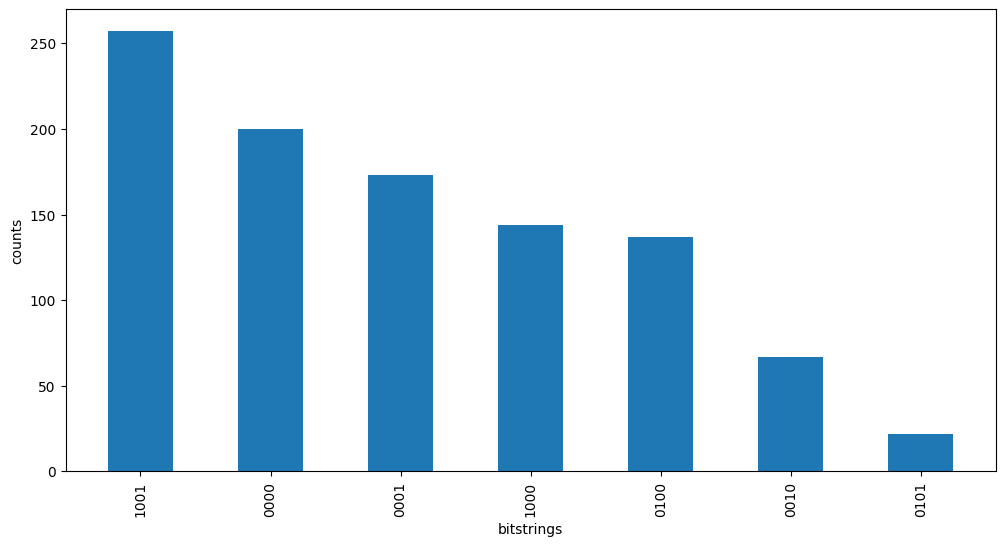

In [19]:
# Plot distribution
plt.figure(figsize=(12, 6))
plt.xlabel("bitstrings")
plt.ylabel("counts")
plt.bar(C.keys(), C.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()

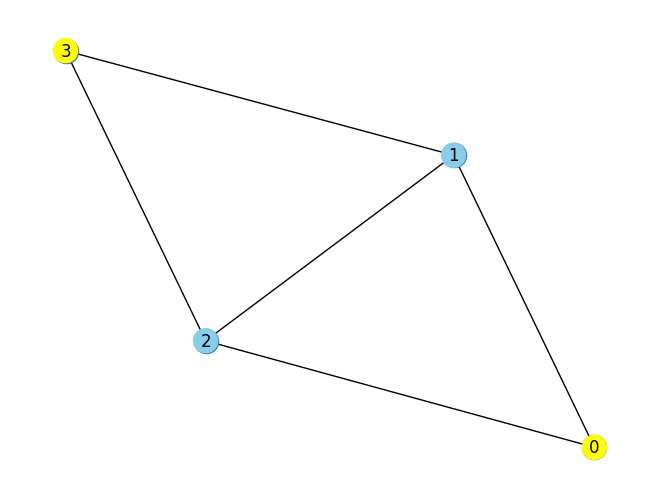

In [200]:
# Highlight solution on the graph
solution = max(most_frequent)

nx.draw(graph, pos=pos)
nx.draw_networkx_labels(graph, pos=pos)

color = []
for i in solution:
    if i == "1":
        color.append("yellow")
    else:
        color.append("skyblue")

nx.draw_networkx_nodes(graph, pos=pos, node_color=color)